## Tracking closed/total issue ratio

Aconex_drakov


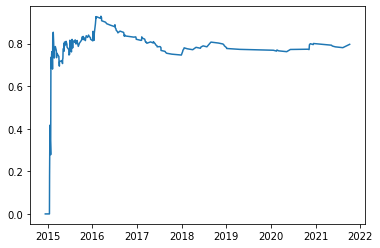

Activiti_Activiti


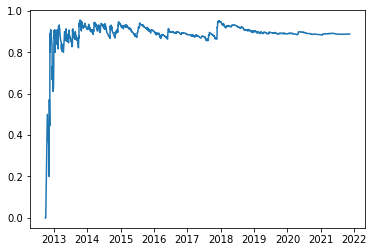

airbnb_lottie-android


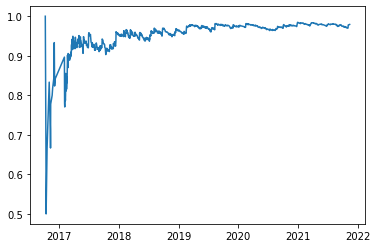

ajeetdsouza_zoxide


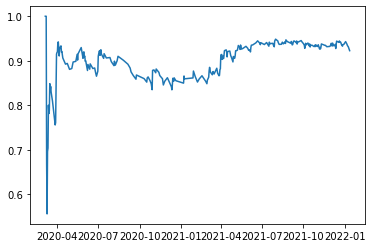

alibaba_arthas


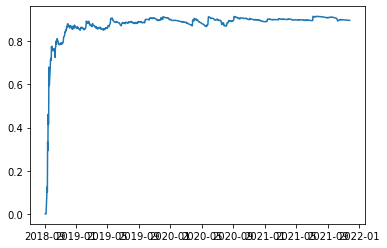

KeyboardInterrupt: 

In [7]:
from pprint import pprint
from functools import reduce
import brotli
import pickle
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import glob

DAYS_THRESHHOLD = 180

def partition_li_alt(predicate, data):
   x = [], []
   for n in data: x[predicate(n)].append(n)
   return x

for p in glob.glob(r".\dump\*\issues.szhat"):
    with open(p, "rb") as handler:
        data = handler.read()
        decompressed_data = brotli.decompress(data)
        issues = pickle.loads(decompressed_data)
        repo_name = p.split("\\")[-2]

        creation_dates = Counter(map(lambda x:x.created_at.date(), issues))
        closed_issues = filter(lambda x: x.closed_at, issues)
        close_dates =  Counter(map(lambda x:x.closed_at.date(), closed_issues))
        all_dates = sorted(set(creation_dates.keys() | close_dates.keys()))

        new_issues_dict = {key: creation_dates.get(key, 0) - close_dates.get(key, 0) for key in all_dates}
        new_issues = sorted(new_issues_dict.items())
        total_issues_dict = {key: creation_dates.get(key, 0) for key in all_dates}
        total_issues = sorted(total_issues_dict.items())

        acc = 0
        open_issues = [acc := acc + x[1] for x in new_issues] 
        acc = 0
        total_issues = [acc := acc + x[1] for x in total_issues] 
        
        closed_ratio = [round(1-op/tot, 4) for op, tot in zip(open_issues, total_issues)]
        print(repo_name)
        plt.plot(list(all_dates), closed_ratio)
        plt.show()
        # print(closed_ration)

## Testing pulse


In [1]:
from pprint import pprint
from functools import reduce
import brotli
import pickle
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import glob

TIME_INTERVAL_DAYS = 90

def get_metric_recent_values(dir_path, metric_type, item_getter):
    with open(f"{dir_path}\\\\{metric_type}.szhat", "rb") as handler:
        decompressed_data = brotli.decompress(handler.read())
    obj = pickle.loads(decompressed_data)
    recent_time = datetime.now() - timedelta(days=TIME_INTERVAL_DAYS) 
    
    return list(filter(lambda x: item_getter(x) > recent_time, obj))

for p in glob.glob(r".\dump\*"):
    repo_name = p.split("\\")[-1]
    metric_getter_pairs = {
        "forks": lambda x: x.created_at,
        "pulls": lambda p: p.created_at,
        "stars": lambda s: s.starred_at
    }

    try:
        for metric in metric_getter_pairs:
                metric_getter_pairs[metric] = get_metric_recent_values(p, metric, metric_getter_pairs[metric])
        numeric_values = list(map(lambda p: (p[0],len(p[1])), metric_getter_pairs.items()))
        print(f"Got {numeric_values} for {repo_name}")
    except FileNotFoundError as f:
            print(f"Got {f} for {repo_name}")
            continue


Got [('forks', 0), ('pulls', 0), ('stars', 1)] for Aconex_drakov
Got [('forks', 60), ('pulls', 11), ('stars', 127)] for Activiti_Activiti
Got [('forks', 59), ('pulls', 18), ('stars', 271)] for airbnb_lottie-android
Got [('forks', 156), ('pulls', 43), ('stars', 638)] for alibaba_arthas
Got [('forks', 47), ('pulls', 18), ('stars', 175)] for alibaba_fastjson
Got [('forks', 170), ('pulls', 16), ('stars', 474)] for alibaba_Sentinel
Got [('forks', 161), ('pulls', 3), ('stars', 495)] for alibaba_spring-cloud-alibaba
Got [('forks', 7), ('pulls', 0), ('stars', 22)] for android-async-http_android-async-http
Got [Errno 2] No such file or directory: '.\\dump\\angular_angular\\\\pulls.szhat' for angular_angular
Got [Errno 2] No such file or directory: '.\\dump\\ansible_ansible\\\\pulls.szhat' for ansible_ansible


## Collecting trends


In [5]:
from pprint import pprint
from functools import reduce
import brotli
import pickle
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import glob

DAYS_THRESHHOLD = 180

def partition_li_alt(predicate, data):
   x = [], []
   for n in data: x[predicate(n)].append(n)
   return x

for p in glob.glob(r".\dump\*\forks.szhat"):
    with (
        open(p, "rb") as handler, 
        # open(p.replace("dump", "intermediate").replace("szhat", "pickle"), "rb") as f
        ):
        data = handler.read()
        decompressed_data = brotli.decompress(data)
        obj = pickle.loads(decompressed_data)
        # metrics = pickle.load(f)

        values = Counter(map(lambda o: o.created_at.date(), obj))
        lists = sorted(values.items()) 
        repo_name = p.split("\\")[-2]
        old_dates, recent_dates = partition_li_alt(lambda d: d[0] >= lists[-1][0] - timedelta(days=DAYS_THRESHHOLD), lists)
        if len(recent_dates) < 5:
            print(f"Not enough recent data for {repo_name}")
            continue
        
        def calc_vel(data):
            arr = [nex[1] - prev[1] for nex, prev in zip(data, data[1:])]
            arr = list(filter(lambda x: x!= 0, arr))

            return partition_li_alt(lambda x: x < 0, arr)
        recent_pos_vel, recent_neg_vel = calc_vel(recent_dates)
        old_pos_vel, old_neg_vel = calc_vel(old_dates)
        
        # old_vel = calc_vel(old_dates)

        print(f"{repo_name}:")
        print(f"RECENT: Pos={len(recent_pos_vel): <4} Neg={len(recent_neg_vel): <4} ABS={sum(recent_pos_vel + recent_neg_vel)}")
        print(f"OLD:    Pos={len(old_pos_vel): <4} Neg={len(old_neg_vel): <4} ABS={sum(old_pos_vel + old_neg_vel)}\n")


Not enough recent data for Aconex_drakov
Activiti_Activiti:
RECENT: Pos=42   Neg=34   ABS=2
OLD:    Pos=804  Neg=811  ABS=-2

airbnb_lottie-android:
RECENT: Pos=32   Neg=35   ABS=0
OLD:    Pos=518  Neg=509  ABS=5

ajeetdsouza_zoxide:
RECENT: Pos=8    Neg=8    ABS=-1
OLD:    Pos=2    Neg=1    ABS=0

alibaba_arthas:
RECENT: Pos=59   Neg=62   ABS=4
OLD:    Pos=414  Neg=396  ABS=-1

alibaba_fastjson:
RECENT: Pos=25   Neg=26   ABS=-1
OLD:    Pos=834  Neg=836  ABS=0



KeyboardInterrupt: 

## Testing distributions

[11, 151, 193, 233, 243, 261, 273, 289, 297, 310, 395, 412, 414, 462, 487, 563, 569, 576, 618, 703, 713, 735, 743, 756, 765, 816, 846, 849, 899, 913, 921, 939, 959, 982, 1016, 1017, 1018, 1038, 1069, 1112, 1124, 1193, 1202, 1207, 1232, 1235, 1292, 1304, 1319, 1335, 1358, 1361, 1370, 1438, 1456, 1489, 1527, 1543, 1599, 1609, 1631, 1639, 1639, 1659, 1674, 1838, 1854, 1864, 1924, 1934, 1965, 2070, 2070, 2081, 2109, 2121, 2203, 2368, 2450, 2480, 2512, 2612, 2746, 2752, 2787, 2803, 2860, 2898, 2947, 2981, 3029, 3096, 3115, 3120, 3170, 3304, 3379, 3406, 3539, 3588, 3620, 3699, 3844, 3867, 3869, 3933, 3937, 3952, 3962, 3985, 4238, 4279, 4403, 4403, 4545, 4753, 4885, 4926, 4950, 5115, 5137, 5172, 5261, 5375, 5405, 5437, 5491, 5492, 5661, 5663, 5803, 5948, 6088, 6118, 6164, 6165, 6402, 6540, 6863, 6896, 6941, 7144, 7600, 7664, 7778, 7811, 7909, 7977, 8827, 9475, 9636, 9860, 9903, 10092, 10460, 10631, 10768, 10817, 11077, 11496, 11541, 11773, 12340, 12790, 13126, 13393, 13443, 14313, 14784, 1582

<BarContainer object of 188 artists>

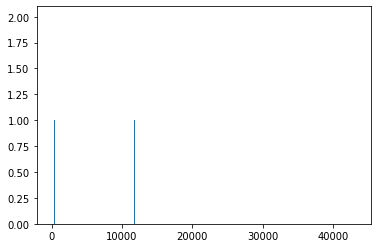

In [15]:
from pprint import pprint
from functools import reduce
import brotli
import pickle
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statistics import stdev, mean
import math
import glob


data = defaultdict(lambda:0)
stars_lst = []

SCALE_FACTOR = 0
METRIC = "commits"
max1 = 0

for p in glob.glob(f".\intermediate\*\{METRIC}.pickle"):
    with open(p, "rb") as file:
        metric = pickle.load(file)
        dic = metric.__dict__
        stars = dic[f"[{METRIC.title()}] Count"]

        # if stars < 20000:
        data[round(stars,-SCALE_FACTOR)] +=1
        stars_lst.append(stars)

lists = sorted(data.items())
stars_array = sorted(data.keys())
x, y = zip(*lists) 

mean_val =mean(stars_lst)
std_val = stdev(stars_lst)
za = 0.50798
print(sorted(stars_lst))
print(f"Mean: {mean_val}")
print(f"StDev: {std_val}")
print(f"Left:{mean_val - std_val*za/math.sqrt(len(stars_lst))} Right: {mean_val + std_val*za/math.sqrt(len(stars_lst))}")
plt.bar(x,y, width=pow(10, SCALE_FACTOR))

## Gathering the data

In [2]:
import glob
import pickle
from collections import defaultdict
from pprint import pprint
import pandas as pd
from main import METRICS, find_missing_metrics


repo_dicts = defaultdict(lambda: {})
metric_dicts = defaultdict(lambda: defaultdict(lambda: {}))
for p in glob.glob(".\intermediate\*\*.pickle"):
    with open(p, "rb") as file:
        metric = pickle.load(file)
        dic = metric.__dict__
        repo_name = dic.pop("repo_name")
        metric_type = p.split('\\')[-1].split(".")[0]

        metric_dicts[metric_type][repo_name] |= dic
        repo_dicts[repo_name] |= dic
        
data = pd.DataFrame.from_dict(repo_dicts)
data.to_csv("metrics.csv",index=True)

print(f"Metrics count: {len(data)}")
print(f"Repo    count: {len(data.keys())}")
print(f"At least {sum(map(len, find_missing_metrics().values()))} metric values are missing")

Metrics count: 107
Repo    count: 222
At least 91 metric values are missing


## Working with the data

In [4]:
name_predicate_pairs= [
    ("Have releases", lambda inner: inner.get("[Releases] Count")),
    ("Have no releases", lambda inner: not inner.get("[Releases] Count")),
    ("Have source code releases", lambda inner: inner.get("[Releases] Count") and not inner.get("[Releases] Total downloads")),
    ("Have binary and source code releases", lambda inner: inner.get("[Releases] Count") and inner.get("[Releases] Total downloads")),
    ]


gathered_data = {
    name: {repo: inner for repo, inner in repo_dicts.items() if func(inner)}
    for name, func in name_predicate_pairs
}

for type, inner in gathered_data.items():
    print(f"{type}: {len(inner)}")
    # display(pd.DataFrame(inner))

Have releases: 152
Have no releases: 70
Have source code releases: 77
Have binary and source code releases: 75


## Calculating correlations

In [87]:
from itertools import combinations_with_replacement
from IPython.display import display, Markdown, Latex

LOWER_BOUND = 0.65

def prune_dict(dct, mask):
    result = {}
    for k, v in mask.items():
        if isinstance(v, dict):
            value = prune_dict(dct[k], v)
            if value:
                result[k] = value
        elif v:
            result[k] = dct[k]
    return result

def print_correlations(dic):
    for g1, g2 in combinations_with_replacement(dic.items(), 2):
        m1, inner_dict1 = g1
        m2, inner_dict2 = g2

        res = {name:inner_dict1[name] | inner_dict2[name] for name in inner_dict1}
        res_df = pd.DataFrame(res).transpose().corr(method='pearson')
        metric1_names = list(list(inner_dict1.values())[0].keys())
        metric2_names = list(list(inner_dict2.values())[0].keys())
        df = res_df[metric1_names].loc[metric2_names]
        
        # df = df[df[df.columns] > 0.7]
        mask = df.where(df != 1).where(df != 0).where(abs(df) > LOWER_BOUND)
        mask = mask.dropna(how="all").dropna(axis="columns", how="all")
        mask = mask.iloc[:, :-1].notnull().astype(float).groupby(level=0).sum().to_dict()
        tmp = prune_dict(df.to_dict(), mask)

        if tmp:
            display(Markdown(f"# {m1} X {m2}"))
            for name, val in tmp.items():   
                # print(tmp)
                display(pd.DataFrame({name: val}))
        # display(pd.DataFrame(df))

# for data, name in zip([data, downloads_data, no_downloads_data], ["correlations", "downloads_correlations", "no_downloads_correlations"]):
values = {name:data.loc[name] for name in data.index}
correlations = pd.DataFrame(values).corr(method='pearson').values
frame = pd.DataFrame(pd.np.triu(correlations), index=data.index, columns=data.index)
frame.to_csv('correlations.csv', index=True)

# print_correlations(metric_dicts)

C:\Users\79134\AppData\Local\Temp/ipykernel_231448/520343286.py:44: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  frame = pd.DataFrame(pd.np.triu(correlations), index=data.index, columns=data.index)
